# Training

## Setup

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import pandas as pd
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
#from torch.autograd import Variable

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
#torch.backends.cudnn.enabled = False
val_size = 5000
test_size = 5000
batch_size = 16
num_workers = 4

transform = transforms.Compose([transforms.ToTensor()])

# Downloading MNIST again :) Training (60k) and test(5k) + val(5k) split
train_loader = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data',
                                            download=True,
                                            train=True,
                                            transform=transform),
                                            batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)

test_dataset = datasets.MNIST('./mnist_data',
                               download=True,
                               train=False,
                               transform=transform)

val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# Test set to compare with DDPM paper
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)

# Validation set so we can keep track of approximated FID score while training
validation_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=16,
                                            shuffle=False, num_workers=num_workers)
    

In [3]:
def f(t, s=torch.tensor([0.008]), T=torch.tensor([1000])):
    return min(torch.cos((t / T + s) / (1 + s) * (torch.pi / 2)).pow(2), 0.99999)

T = 1000
ts = torch.arange(T)
alpha_bar = torch.tensor([min(f(t)/f(torch.tensor([0])),0.999) for t in ts]) 
beta = torch.tensor([1 - alpha_bar[t]/(alpha_bar[t-1]) if t > 0 else torch.tensor([0]) for t in ts])
alpha = 1 - beta
alpha = alpha.view((1000, 1, 1, 1)).to(device)
beta = beta.view((1000, 1, 1, 1)).to(device)
alpha_bar = alpha_bar.view((1000, 1, 1, 1)).to(device)

In [4]:
# Sets up alpha_bar for training and test so alpha_bar_t = alpha_bar[t]
T = 1000
beta_start, beta_end = [1e-4, 2e-02]
beta = torch.linspace(beta_start, beta_end, T)
alpha = 1-beta
alpha_bar = alpha.clone()
for e in range(T-1):
    alpha_bar[e+1] *= alpha_bar[e]

alpha = alpha.view((1000, 1, 1, 1)).to(device)
beta = beta.view((1000, 1, 1, 1)).to(device)
alpha_bar = alpha_bar.view((1000, 1, 1, 1)).to(device)

## Model

In [14]:
class UNET(torch.nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        channels = [32, 64, 128, 256]
        self.relu = nn.ReLU()
        self.convs_attention = [nn.Conv2d(i, 1, 1) for i in [128, 64, 32]]
        self.convs_attention = nn.ModuleList(self.convs_attention)
        self.sigmoid = nn.Sigmoid()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(2, channels[0], kernel_size=3, padding=1),  # (batchsize, 32, 28, 28)
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 32, 14, 14)
                nn.Conv2d(channels[0], channels[1], kernel_size=3, padding=1),  # (batchsize, 64, 14, 14)
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 64, 7, 7)
                nn.Conv2d(channels[1], channels[2], kernel_size=3, padding=1),  # (batchsize, 128, 7, 7)
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.MaxPool2d(2, padding=1),  # (batchsize, 128, 4, 4)
                nn.Conv2d(channels[2], channels[3], kernel_size=3, padding=1),  # (batchsize, 256, 4, 4)
                nn.ReLU(),
            )
        ])

        self.tconvs = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(channels[3], channels[2], kernel_size=3, 
                                   stride=2, padding=1, output_padding=0),   # (batchsize, 128, 7, 7)
                nn.ReLU()
            ),
            nn.Sequential(
                nn.ConvTranspose2d(channels[2], channels[1], kernel_size=3,
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 64, 14, 14)
                nn.ReLU()
            ),
            nn.Sequential(
                nn.ConvTranspose2d(channels[1], channels[0], kernel_size=3, 
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 32, 28, 28)
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(channels[0],channels[0],kernel_size=3,padding=1),  # (batchsize, 32, 28, 28)
                nn.ReLU(),
                nn.Conv2d(channels[0],1,kernel_size=1) # (batchsize, 1, 28, 28)
            )      
        ])

    def attention_block(self, x, g, iter_num):
        # x er fra skip-connections, g er nedefra (fra t-convs)
        x = (x - torch.mean(x)) / torch.std(x)
        #g = (g - torch.mean(g)) / torch.std(g)
        res = self.relu(torch.add(x, g))
        res = self.sigmoid(self.convs_attention[iter_num](res))
        res = torch.mul(x, res)
        return res
        
        
    def forward(self, x, t): 
        x_trans = torch.cat((x, t), dim=-3)
        signal = x_trans
        signals = []

        for i, conv in enumerate(self.convs):
            # print(f"conv {i}")
            signal = conv(signal)
            # print(signal.shape)
            if i < len(conv):
                signals.append(signal)
        
        for i, tconv in enumerate(self.tconvs):
            # print(f"tconv {i}")
            # print(f"signal shape: {signal.shape}")
            if i == 0:
                signal = tconv(signal)
            else:
                signal = self.attention_block(signals[-i], signal, i-1)
                signal = tconv(signal)
        return signal

## Training loop

In [15]:
#from UNET import UNET
epochs = 20
model = UNET()
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss(reduction="sum")
running_loss = 0

In [16]:
for epoch in range(epochs):
    for e, data in enumerate(train_loader):
        x0, _ = data
        x0 = x0.to(device)
        t = torch.randint(1, T+1, (batch_size,)).to(device)
        eps = torch.randn(batch_size, 1, 28, 28).to(device)
        # print(eps.shape)
        # print(x0.shape)
        loss = criterion(eps, model(torch.sqrt(alpha_bar[t-1]) * x0 + 
                                    torch.sqrt(1 - alpha_bar[t-1]) * eps, t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 28, 28)))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        if e % 100 == 99:
            print(f'{epoch, e+1}, loss: {running_loss:.3f}')
            running_loss = 0.0
        
    if epoch % 5 == 4:
        torch.save(model.state_dict(), f"DDPM_{epoch}.pth")

(0, 100), loss: 1255983.892
(0, 200), loss: 1248999.861
(0, 300), loss: 737596.429
(0, 400), loss: 213257.481
(0, 500), loss: 162281.977
(0, 600), loss: 150298.658
(0, 700), loss: 130774.483
(0, 800), loss: 124556.714
(0, 900), loss: 115610.000
(0, 1000), loss: 98599.023
(0, 1100), loss: 99232.525
(0, 1200), loss: 93927.941
(0, 1300), loss: 101457.683
(0, 1400), loss: 97409.642
(0, 1500), loss: 84902.948
(0, 1600), loss: 100722.324
(0, 1700), loss: 87278.003
(0, 1800), loss: 91724.527
(0, 1900), loss: 77018.104
(0, 2000), loss: 80400.894
(0, 2100), loss: 86284.714
(0, 2200), loss: 89190.753
(0, 2300), loss: 79691.510
(0, 2400), loss: 78424.656
(0, 2500), loss: 73924.738
(0, 2600), loss: 74731.778
(0, 2700), loss: 70937.353
(0, 2800), loss: 76137.517
(0, 2900), loss: 72241.253
(0, 3000), loss: 66463.484
(0, 3100), loss: 68828.494
(0, 3200), loss: 74108.298
(0, 3300), loss: 69042.471
(0, 3400), loss: 70040.519
(0, 3500), loss: 69315.271
(0, 3600), loss: 70015.792
(0, 3700), loss: 71444.1

KeyboardInterrupt: 

# Sampling

In [17]:
import matplotlib.pyplot as plt
model.eval()

UNET(
  (relu): ReLU()
  (convs_attention): ModuleList(
    (0): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  )
  (sigmoid): Sigmoid()
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
    )
    (2): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
    )
    (3): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
      (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

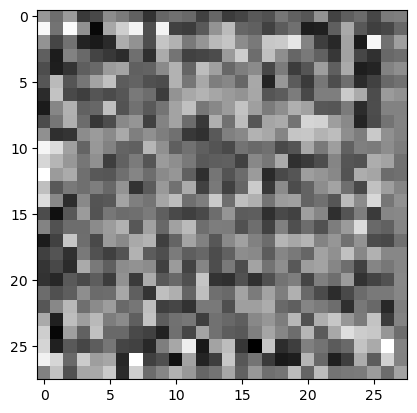

In [18]:
batch_size = 1
xt = torch.randn(batch_size, 1, 28, 28).to(device)

for t in torch.arange(T, 0, -1):
    #print(t)
    t = t.to(device)
    z = torch.randn(batch_size, 1, 28, 28).to(device) if t > 1 else torch.zeros(batch_size, 1, 28, 28).to(device)
    xt_new = 1 / torch.sqrt(alpha[t - 1]) * (xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1])) * 
                                                   model(xt, t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 28, 28))) + torch.sqrt(beta[t-1]) * z
    xt = xt_new
    #if t == 1:
        #print((xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1]))))
plt.imshow(xt[0][0].cpu().detach().numpy(), cmap="grey")

In [41]:
torch.set_printoptions(precision=10)
alpha_bar[0]

tensor([[[0.9998999834]]], device='cuda:0')

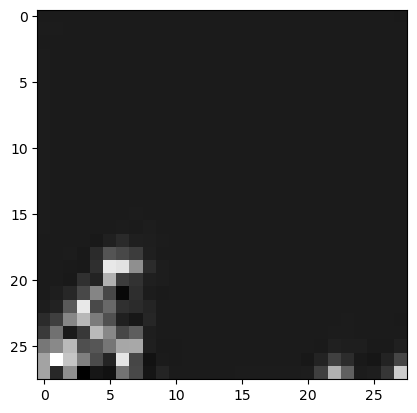

In [42]:
plt.imshow(xt[0][0].cpu().detach().numpy(), cmap="grey")